まずCSVfileをDataFrameにする

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data_train = pd.read_csv('train1.csv')
data_test = pd.read_csv('test1.csv')

In [2]:
data_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
395,396,0,3,"Johansson, Mr. Erik",male,22.0,0,0,350052,7.7958,NaN,S
440,441,1,2,"Hart, Mrs. Benjamin (Esther Ada Bloomfield)",female,45.0,1,1,F.C.C. 13529,26.2500,NaN,S


データを可視化してみよう！

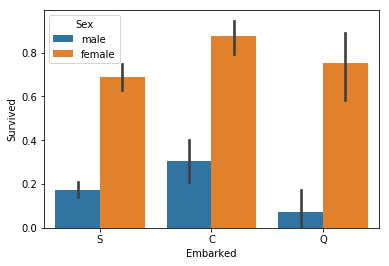

In [3]:
sns.barplot(x='Embarked',y="Survived",hue="Sex",data = data_train);

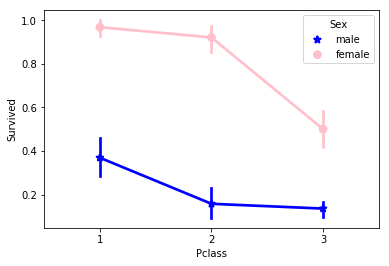

In [4]:
sns.pointplot(x="Pclass",y="Survived",hue="Sex",data=data_train,
             palette={'male':"blue","female":"pink"},
             markers=["*","o"],linestyle=["-","--"]);

特徴量をいじる

In [5]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

In [6]:
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [7]:
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

In [8]:
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df   

In [9]:
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

In [10]:
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [11]:
data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


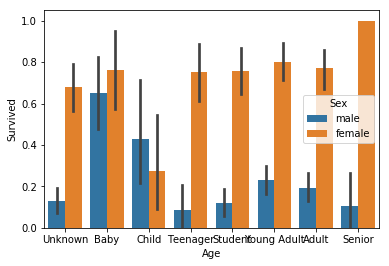

In [12]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

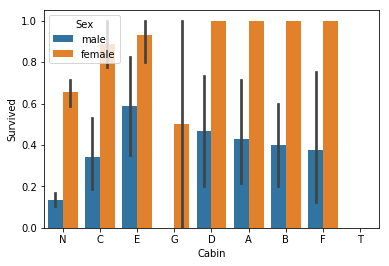

In [13]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

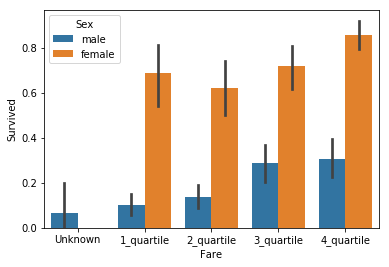

In [14]:
sns.barplot(x="Fare", y="Survived", hue="Sex", data=data_train);

エンコーディングするよ

In [15]:
from sklearn import preprocessing
def encode_features(df_train,df_test):
    features = ['Fare','Cabin','Age','Sex','Lname','NamePrefix']
    df_combined = pd.concat([df_train[features],df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train,df_test

In [16]:
data_train,data_test = encode_features(data_train,data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


データを分けるよ

In [18]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived','PassengerId'],axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train,X_test,y_train,y_test = train_test_split(X_all,y_all,test_size=num_test,random_state=23)

トレーニングアルゴリズム

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

#Choose the type of classifier
clf = RandomForestClassifier()

#Choose some parameter combinations to try
parameters = {'n_estimators':[4,6,9],
             'max_features':['log2','sqrt','auto'],
             'criterion':['entropy','gini'],
             'max_depth':[2,3,5,10],
             'min_samples_split':[2,3,5],
             'min_samples_leaf':[1,5,8]}

In [21]:
# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=6, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [22]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.815642458101


In [23]:
from sklearn.cross_validation import KFold

def run_kfold(clf):
    kf = KFold(891, n_folds=10)
    outcomes = []
    fold = 0
    for train_index, test_index in kf:
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)


Fold 1 accuracy: 0.7888888888888889
Fold 2 accuracy: 0.8651685393258427
Fold 3 accuracy: 0.797752808988764
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.8314606741573034
Fold 6 accuracy: 0.8089887640449438
Fold 7 accuracy: 0.8089887640449438
Fold 8 accuracy: 0.8764044943820225
Fold 9 accuracy: 0.8876404494382022
Fold 10 accuracy: 0.8202247191011236
Mean Accuracy: 0.8328214731585518


/Users/zxbp2w/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
